# Field Paper 

Flabbi 2010 with position change (promotion) dynamic

Estimated on German SOEP 2000-2017 (wage in real 2010 euros)

In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd
import scipy 
import itertools

# Data viz
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

# Estimation
from scipy.optimize import minimize
import scipy.stats as stats
# import numdifftools as ndt
import scipy.integrate as integrate

# General
import pdb

## Data Cleaning (all in Stata)

In [4]:
df=pd.read_stata('workfile.dta', columns=['sex','employed', 'flex_sched_score', 'hrwage', 'dur']) #986,337 obs from 1984-2017; 711,205 for 2000-2017

In [5]:
df.head()

,sex,employed,flex_sched_score,hrwage,dur
0,male,1.0,1.0,21.000000,NaN
1,male,1.0,1.0,72.115250,NaN
2,male,1.0,0.0,72.115250,NaN
3,male,1.0,1.0,59.895748,NaN
4,female,1.0,0.0,17.307501,NaN


### Homogeneity: college degree or more, age 25-55 (Stata)

### Employed

In [10]:
empl_df = df[df['employed']==1]

In [7]:
len(empl_df) #2454

2454

In [8]:
min(empl_df['hrwage'])

0.00800000037997961

### Non-Employed

Also college degree or more, listed as not employed (& not employer). Removes students and retirees.

In [11]:
unempl_df = df[df['employed']==0]
len(unempl_df) #54

54

In [12]:
f_unempl = unempl_df[unempl_df['sex'] == 'female'] #27
m_unempl = unempl_df[unempl_df['sex'] == 'male'] #27

In [16]:
f_empl = empl_df[empl_df['sex'] == 'female'] #1212
m_empl = empl_df[empl_df['sex'] == 'male'] #1242

### Distribution of Wages

/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


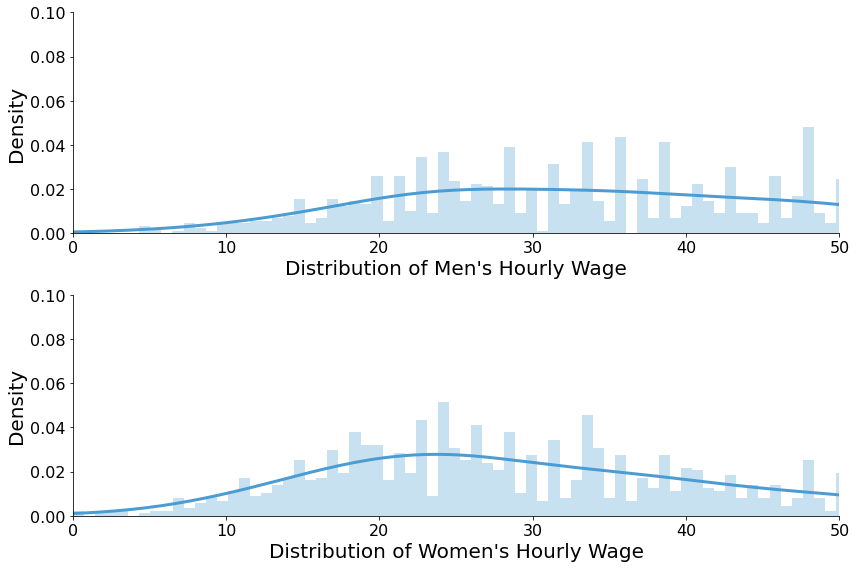

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.distplot(m_empl['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[0])
sns.distplot(f_empl['hrwage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=100, ax=ax[1])

#ax[0].legend(['Men'])
#ax[1].legend(['Women']) 

ax[0].set_xlim([0,50])
ax[1].set_xlim([0,50])

ax[0].set_ylim([0,0.1])
ax[1].set_ylim([0,0.1])

ax[0].set(xlabel="Distribution of Men's Hourly Wage")
ax[1].set(xlabel="Distribution of Women's Hourly Wage")

plt.tight_layout()

# fig.savefig('./figures/wage_noMin.png', bbox_inches='tight', transparent=True)

# Estimation

### Data
2000-2017, college graduate or more, 

- empl_df : all employed
- f_empl: employed females
- m_empl: employed males

- unempl_df: all unemployed
- f_unempl: unemployed females
- m_unempl: unemployed males

## Log-Likelihood

### Without Distributional Assumptions

In [20]:
# # Vector of minimum wages for rank
# UMk = m_empl.groupby('rank').agg({'hrwageR': min}).values
# UFk = f_empl.groupby('rank').agg({'hrwageR': min}).values

# Vector of minimum wages for concentrated rank
UMk = m_empl.groupby('flex_sched_score').agg({'hrwage': min}).values
UFk = f_empl.groupby('flex_sched_score').agg({'hrwage': min}).values

In [21]:
len(UMk)

3

### Log-Normal Functions

In [22]:
def lognormpdf(x: np.array, μ: float, σ: float):
    """
    Calculates lognormal pdf without stats packages
    """
    
    denom = x * σ * np.sqrt(2*np.pi)
    exp_num = -(np.log(x)-μ)**2
    exp_denom = 2 * σ * σ
    num = np.exp(exp_num/exp_denom)
    
    return num/denom

In [23]:
def lognormsf(x: np.array, μ: float, σ: float):
    """
    Calculated lognormal cdf with scipy.stats normal cdf
    """
    
    lnx = np.log(x)
    num = lnx - μ
    denom = σ
    
    return 1-stats.norm.cdf(num/denom)

### Functions for Not Prejudiced (and Men)

In [24]:
def sumN(k:np.array, α:float, τ_0: float, ρ: float, η:float):
    frac = τ_0 / (ρ + η + τ_0)
    
    summand = 0 
    for i in range(len(k)):
        if i==0:
            continue
        else:
            summand += (α**(i-1)) * ((frac)**(i)) * k[i] 

    return summand[0]

In [38]:
sumN(UFk, α, τ_0, ρ, ηF)

0.31540573

In [26]:
def sumNumN(k:np.array, α:float, τ_0: float, ρ: float, η:float):
    frac = τ_0 / (ρ + η + τ_0)
    
    summand = 0 
    for i in range(len(k)):
        if i==0:
            continue
        else:
            summand += (α**(i-1)) * ((frac)**(i))
    
    return summand

In [39]:
sumNumN(UFk, α, τ_0, ρ, ηF)

0.5386818769966869

In [27]:
def sumDenomN(k: np.array, α:float, τ_0: float, ρ: float, η:float):
    num = α*τ_0
    denom = ρ + η + τ_0
    
    frac = num/denom
    
    summand = 0 
    
    for i in range(len(k)):
        if i==0:
            continue
        else:
            summand += (frac)**(i)
    
    return summand

In [40]:
sumDenomN(UFk, α, τ_0, ρ, ηF)

0.26934093849834345

In [28]:
def emplN(x:np.array, k:np.array, α:float, τ_0:float, ρ:float, η:float, μ:float, σ: float):
    """
    Accepted Wages for Men and Women at Unprejudiced
    
    Requires sumN(k,α,τ_0,ρ,η), sumNumN(k,α,τ_0,ρ,η), and sumDenomN(k,α,τ_0,ρ,η)
    """
     
    num_num = x - (1-α)*( (ρ+τ_0)*k[0] - ( (1-α)*(ρ+τ_0) + η) * sumN(k, α, τ_0, ρ, η) )
    num_denom =  α * ( 1 - (1-α)*sumNumN(k,α,τ_0,ρ,η) )
    
    num = (1/num_denom) * lognormpdf(num_num/num_denom, μ, σ)
                         
    denom_num = (ρ + τ_0)*k[0] + ( (1-α)*(ρ+τ_0) + η)* sumN(k, α, τ_0, ρ, η)
    denom_denom = 1 - sumDenomN(k,α,τ_0,ρ,η)
                         
    denom = lognormsf(denom_num/denom_denom, μ, σ)
    
    return num/denom

In [42]:
prodM = m_empl['hrwage'] - (1-α)*( (ρ+τ_0)*UMk[0] - ( (1-α)*(ρ+τ_0) + ηM) * sumN(UMk, α, τ_0, ρ, ηM) )

In [43]:
prodM.mean()

42.95147

In [44]:
prodM.std()

18.955248

In [45]:
prodF = f_empl['hrwage'] - (1-α)*( (ρ+τ_0)*UFk[0] - ( (1-α)*(ρ+τ_0) + ηF) * sumN(UFk, α, τ_0, ρ, ηF) )

In [46]:
prodF.mean()

33.503273

In [47]:
prodF.std()

16.966492

In [50]:
emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, ηF, μF, σF)

4       0.000300
5       0.000161
8       0.000090
11      0.000484
12      0.000430
          ...   
2500    0.000341
2501    0.000209
2504    0.000142
2505    0.000117
2507    0.000246
Name: hrwage, Length: 1212, dtype: float64

In [29]:
def hazardM(k: np.array, α:float, τ_0:float, ρ:float, η:float, λ: float, μ: float, σ: float):
    """
    Calculates the hazard rate out of unemployment for men = probability of receiving an acceptable job offer
    
    Uses the same denominator as emplM
    
    Requires sumM(k, α, τ_0, ρ, η) and sumDenomM(k,α,τ_0,ρ,η)

    """
    
    denom_num = (ρ + τ_0)*k[0] + ( (1-α)*(ρ+τ_0) + η)* sumN(k, α, τ_0, ρ, η)
    denom_denom = 1- sumDenomN(k,α,τ_0,ρ,η)
                         
    denom = lognormsf(denom_num/denom_denom, μ, σ)
    
    return (λ * denom)[0]

In [51]:
hazardM(UMk, α, τ_0, ρ, ηM, λM, μM, σM)

0.5512735517597809

### Functions for Women

In [30]:
def sumP(k:np.array, α:float, τ_0: float, ρ: float, η:float):
    frac = τ_0 / (ρ + η + τ_0)
    
    summand = 0 
    for i in range(len(k)):
        if i==0:
            continue
        else:
            summand += (α**(i-1)) * ((frac)**(i))
    
    return summand

In [52]:
sumP(UFk, α, τ_0, ρ, ηF)

0.5386818769966869

In [31]:
def sumNumP(k:np.array, d:np.array, α:float, τ_1:float, ρ:float, η:float):
    summand = 0
    
    for i in range(len(k)):
        if i==0:
            continue
        else:
            mult = ( (1-α)*(ρ+τ_1) + η)*k[i] - α*d[i]
        
            num = τ_1
            denom = ρ + η + τ_1
    
            frac = (num/denom)**(i)
        
            summand += mult * frac

    return summand[0]

In [53]:
d = np.array([d1,d2,d3,d4,d5])
sumNumP(UFk, d, α, τ_1, ρ, ηF)

-0.34886497

In [32]:
def sumDenomP(k:np.array, d:np.array, α:float, τ_1:float, ρ:float, η:float):
    summand = 0
    
    for i in range(len(k)):
        if i==0:
            continue
        else:
            mult = ( (1-α)*(ρ+τ_1) + η)*k[i] - α*d[i]
        
            num = τ_1
            denom = ρ + η + τ_1
    
            frac = (num/denom)**(i)
        
            summand += mult * (α**(i-1)) * frac

    return summand[0]

In [54]:
d = np.array([d1,d2,d3,d4,d5])
sumDenomP(UFk, d, α, τ_1, ρ, ηF)

-0.38771784

In [33]:
def emplP(x:np.array, k:np.array, d:np.array, α:float, τ_1:float, ρ:float, η:float, μ:float, σ: float):
    """
    Accepted Wages for Women at Prejudiced Employers
    
    Requires sumNumP(k, d, α, τ_1, ρ, η), sumP(k,α,τ_1,ρ,η), sumDenomP(k,d,α,τ_1,ρ,η) and sumDenomN(k,α,τ_1,ρ,η)
    """
    
    num_num = x + α*d[0] - (1-α)*(ρ+τ_1)*k[0] - (1-α)*sumNumP(k, d, α, τ_1, ρ, η)
    num_denom = α * ( 1 - (1-α) * sumP(k,α,τ_1,ρ,η) )
    
    num = (1/num_denom) * lognormpdf(num_num/num_denom, μ, σ)
    
    denom_num = (ρ + τ_1)*k[0] + d[0] + sumDenomP(k,d,α,τ_1,ρ,η)
    denom_denom = 1- sumDenomN(k,α,τ_1,ρ,η)
                         
    denom = lognormsf(denom_num/denom_denom, μ, σ)
    
    return num/denom

In [56]:
emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, ηF, μF, σF)

4       0.000292
5       0.000159
8       0.000090
11      0.000462
12      0.000414
          ...   
2500    0.000331
2501    0.000205
2504    0.000140
2505    0.000116
2507    0.000241
Name: hrwage, Length: 1212, dtype: float64

In [57]:
def hazardF(k: np.array, d:np.array, α:float, τ_0:float, τ_1:float,  ρ:float, η:float, λ: float, μ: float, σ: float, p:float):
    """
    Calculates the hazard rate out of unemployment for women = probability of receiving an acceptable job offer
    
    Uses the denominators for not prejudiced and for prejudiced
    """

    denom_numN = (ρ + τ_0)*k[0] + ( (1-α)*(ρ+τ_0) + η)* sumN(k, α, τ_0, ρ, η)
    denom_denomN = 1 - sumDenomN(k,α,τ_0,ρ,η)
                         
    denomN = lognormsf(denom_numN/denom_denomN, μ, σ)
    
    denom_numP = (ρ + τ_1)*k[0] + d[0] + sumDenomP(k,d,α,τ_1,ρ,η)
    denom_denomP = 1- sumDenomN(k,α,τ_1,ρ,η)
                         
    denomP = lognormsf(denom_numP/denom_denomP, μ, σ)
    
    mult = (p * denomP) + ((1-p)*denomN)
    
    return (λ * mult)[0]

In [58]:
hazardF(UFk, d, α, τ_0, τ_1,  ρ, ηF, λF, μF, σF, p)

0.44693309786944757

### Test Statistics

In [35]:
def teststats (hess_inv: np.ndarray, lnL: float, nparams: int):
    """
    Calculates the standard errors and p value from the LR tests
    """
    se = np.sqrt(np.diag(hess_inv))
    
    loglik_H0 = lnL_6 # Update for the test statistics!
    
    LR = 2 * (lnL - loglik_H0)
    pval = stats.chi2.pdf(LR, nparams)
    
    ts = se.tolist()
    ts.append(lnL)
    ts.append(pval)
    
    return ts

### Initial Conditions

Copied from Master's Thesis, SOEP Replication

In [49]:
d1=1
d2=2
d3=3
d4=4
d5=5
d6=d7=d8=d9=d10=d11=d12=d13=5

p = 0.5

α = 0.5

τ_0 = 0.5
τ_1 = 0.5
ρ = 0.5

ηF = 0.133
ηM = 0.108

λF = 0.457
λM = 0.558

μF = prodF.mean()
σF = prodF.std()
μM = prodM.mean()
σM = prodM.std()

### Log-Likelihood

#### Total Heterogeneity (6)

In [61]:
def logLik(param:list):
    """
    Log-Likehood with all values gender specific 
    """
    
    α = 0.5
    
    p = np.exp(param[0])

    τ_0 = np.exp(param[1])
    τ_1 = np.exp(param[2])
    ρ = np.exp(param[3])

    ηF = np.exp(param[4])
    ηM = np.exp(param[5])

    λF = np.exp(param[6])
    λM = np.exp(param[7])

    μF = param[8]
    σF = np.exp(param[9])
    μM = param[10]
    σM = np.exp(param[11])
    
    d1 = np.exp(param[12])
    d2 = np.exp(param[13])
    d3 = np.exp(param[14])
    d4 = np.exp(param[15])
    d5 = np.exp(param[16])
    
    d = np.array([d1,d2,d3,d4,d5])

    # Men Log(hazard) and Log(termination) equations
    hM = hazardM(UMk, α, τ_0, ρ, ηM, λM, μM, σM)
    
    a = hM / (hM + ηM)
    aa = len(m_unempl) + len(m_empl)
    A = (aa * np.log(a) ) + (len(m_unempl) * np.log(ηM))

    # Women Log(hazard) and Log(termination) equations
    hF = hazardF(UFk, d, α, τ_0, τ_1, ρ, ηF, λF, μF, σF, p)
    
    b = hF / (hF + ηF)
    bb = len(f_unempl) + len(f_empl)
    B = (bb * np.log(b)) + (len(f_unempl) * np.log(ηF))
    
    # Men and Women Unemployment Duration
    c = hM*np.sum(m_unempl['dur'])
    cc = hF*np.sum(f_unempl['dur'])
    C = c + cc
   
    # Women Employed equations
    e = (1-p) * emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, ηF, μF, σF) 
    ee = p * emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, ηF, μF, σF)
    E = np.sum ( np.log( e + ee ) )
    
    # Men Employed Equations
    F = np.sum ( np.log( emplN(m_empl['hrwage'],UMk, α, τ_0, ρ, ηM, μM, σM) ) )
    
    return -(A + B - C + E + F)

In [62]:
# Check on log-likelihood

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13]
param = np.log([p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, np.exp(μF), σF, np.exp(μM), σM, d1,d2,d3,d4,d5])

print(logLik(param))

23402.65399064587


In [63]:
est_6 = minimize(logLik, param, method='L-BFGS-B')

est_6

      fun: 22709.058918371145
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.82299119,  0.        ,  0.        ,  0.        , -1.30348781,
       -0.47984941,  2.06309779, -1.00990292,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 378
      nit: 11
     njev: 21
   status: 0
  success: True
        x: array([-2.50469419, -0.69772839, -0.69314718, -0.38154531, -6.72352922,
       -6.82846682, -2.84829759, -2.96966251, 33.50327298,  2.83124032,
       42.9514694 ,  2.94208083,  0.        ,  0.69314718,  1.09861229,
        1.38629436,  1.60943791])

In [64]:
# Coefficients (L-BFGS-B)

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2]

p_6 = np.exp(est_6.x[0])
τ_0_6 = np.exp(est_6.x[1]) 
τ_1_6 = np.exp(est_6.x[2]) 
ρ_6 = np.exp(est_6.x[3])
ηF_6 = np.exp(est_6.x[4])
ηM_6 = np.exp(est_6.x[5])
λF_6 = np.exp(est_6.x[6])
λM_6 = np.exp(est_6.x[7])
μF_6 = est_6.x[8]
σF_6 = np.exp(est_6.x[9])
μM_6 = est_6.x[10]
σM_6 = np.exp(est_6.x[11])
d1_6  = np.exp(est_6.x[12])
d2_6  = np.exp(est_6.x[13])
d3_6  = np.exp(est_6.x[14])
d4_6  = np.exp(est_6.x[15])
d5_6  = np.exp(est_6.x[16])

coeff_6 = [p_6, τ_0_6, τ_1_6, ρ_6, ηF_6, ηM_6, λF_6, λM_6, μF_6, σF_6, μM_6, σM_6, d1_6, d2_6, d3_6, d4_6, d5_6]

print(coeff_6)

[0.08170057942192527, 0.4977146352404106, 0.5, 0.6828054451814668, 0.0012022875830758229, 0.0010825165395145914, 0.057942879214305375, 0.05132062750683627, 33.503272977314445, 16.966491699218754, 42.95146939623577, 18.95524787902832, 1.0, 2.0, 3.0000000000000004, 4.0, 4.999999999999999]


In [65]:
lnL_6 = est_6.fun

print(lnL_6)

22709.058918371145


In [66]:
ts_6 = teststats(est_6.hess_inv, lnL_6, len(coeff_6)) #.todense() to recover <17x17 LbfgsInvHessProduct with dtype=float64> object

print(ts_6)

ValueError: Input must be 1- or 2-d.

### Same Productivity, Prejudice

In [71]:
def logLik5(param:list):
    """
    Log-Likehood with the same productivity by gender but there is the presence of prejudice
    """
    
    α = 0.5
    
    p = np.exp(param[0])

    τ_0 = np.exp(param[1])
    τ_1 = np.exp(param[2])
    ρ = np.exp(param[3])

    ηF = np.exp(param[4])
    ηM = np.exp(param[5])

    λF = np.exp(param[6])
    λM = np.exp(param[7])

    μ = param[8]
    σ = np.exp(param[9])
    
    d = np.array(np.exp([param[10],param[11],param[12],param[13],param[14]]))
#     d = [param[12],param[13]] ,param[17],param[18],param[19],param[20],param[21],param[22]

    # Men Log(hazard) and Log(termination) equations
    hM = hazardM(UMk, α, τ_0, ρ, ηM, λM, μ, σ)
    
    a = hM / (hM + ηM)
    aa = len(m_unempl) + len(m_empl)
    A = (aa * np.log(a) )+ (len(m_unempl) * np.log(ηM))

    # Women Log(hazard) and Log(termination) equations
    hF = hazardF(UFk, d, α, τ_0, τ_1, ρ, ηF, λF, μ, σ, p)
    
    b = hF / (hF + ηF)
    bb = len(f_unempl) + len(f_empl)
    B = (bb * np.log(b)) + (len(f_unempl) * np.log(ηF))
    
    # Men and Women Unemployment Duration
    c = hM*np.sum(m_unempl['dur'])
    cc = hF*np.sum(f_unempl['dur'])
    C = c + cc
   
    # Women Employed equations
    e = (1-p) * emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, ηF, μ, σ) 
    ee = p * emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, ηF, μ, σ)
    E = np.sum ( np.log( e + ee ) )
    
    # Men Employed Equations
    F = np.sum ( np.log( emplN(m_empl['hrwage'],UMk, α, τ_0, ρ, ηM, μ, σ) ) )
    
    return (-(A + B - C + E + F))

In [72]:
# Check on log-likelihood

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13]
param_prej = np.log([p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, np.exp(μM), σM, d1,d2,d3,d4,d5])

print(logLik5(param_prej))

24273.731357635716


In [73]:
est_5 = minimize(logLik5, param_prej, method='L-BFGS-B')

est_5

      fun: 23728.984904855864
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.46998459e+00,  3.93124608e+03,  0.00000000e+00,  1.41855708e+01,
       -2.63473317e+01, -2.39913769e+01,  1.63381629e+00,  1.66801329e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 448
      nit: 6
     njev: 28
   status: 0
  success: True
        x: array([ -1.45383211,  -0.9077103 ,  -0.59201483,  -1.02293762,
       -12.91396358, -10.72014816,  -5.35532451,  -4.66605923,
        42.9514694 ,   2.94208083,   0.        ,   0.69314718,
         1.09861229,   1.38629436,   1.60943791])

In [74]:
# Coefficients

p_5 = np.exp(est_5.x[0])
τ_0_5 = np.exp(est_5.x[1]) 
τ_1_5 = np.exp(est_5.x[2]) 
ρ_5 = np.exp(est_5.x[3])
ηF_5 = np.exp(est_5.x[4])
ηM_5 = np.exp(est_5.x[5])
λF_5 = np.exp(est_5.x[6])
λM_5 = np.exp(est_5.x[7])
μ_5 = est_5.x[8]
σ_5 = np.exp(est_5.x[9])
d1_6  = np.exp(est_5.x[10])
d2_6  = np.exp(est_5.x[11])
d3_6  = np.exp(est_5.x[12])
d4_6  = np.exp(est_5.x[13])
d5_6  = np.exp(est_5.x[14])

coeff_5 = [p_5, τ_0_5, τ_1_5, ρ_5, ηF_5, ηM_5, λF_5, λM_5, μ_5, σ_5, d1_6, d2_6, d3_6, d4_6, d5_6]

print(coeff_5)

[0.2336731082225101, 0.4034469384883166, 0.5532115346660528, 0.3595372045984194, 2.4634110082059676e-06, 2.2095244302598667e-05, 0.004722936585239039, 0.009409276393857764, 42.95146939623577, 18.95524787902832, 1.0, 2.0, 3.0000000000000004, 4.0, 4.999999999999999]


In [75]:
lnL_5 = est_5.fun

print(lnL_5)

23728.984904855864


In [76]:
ts_5 = teststats(est_5.hess_inv.todense(), lnL_5, 15)

print(ts_5)

[1.0528142732797925, 0.40238244607460355, 0.5364695519867737, 1.0518449115431099, 6.085646164976848, 4.06802175026315, 1.2302027317144724, 2.003073420868192, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 23728.984904855864, 0.0]


#### Heterogeneous productivity, No Prejudice (4)

In [77]:
def logLik4(param:list):
    """
    Log-Likehood with only 
    """
    
    α = 0.5
    
    p = 0

    τ_0 = np.exp(param[0])
    τ_1 = np.exp(param[0])
    ρ = np.exp(param[1])

    ηF = np.exp(param[2])
    ηM = np.exp(param[3])

    λF = np.exp(param[4])
    λM = np.exp(param[5])

    μF = param[6]
    σF = np.exp(param[7])
    μM = param[8]
    σM = np.exp(param[9])
    
    d = np.array([0,0,0,0,0])
#     d = [param[12],param[13]] ,param[17],param[18],param[19],param[20],param[21],param[22]

    # Men Log(hazard) and Log(termination) equations
    hM = hazardM(UMk, α, τ_0, ρ, ηM, λM, μM, σM)
    
    a = hM / (hM + ηM)
    aa = len(m_unempl) + len(m_empl)
    A = (aa * np.log(a) )+ (len(m_unempl) * np.log(ηM))

    # Women Log(hazard) and Log(termination) equations
    hF = hazardF(UFk, d, α, τ_0, τ_1, ρ, ηF, λF, μF, σF, p)
    
    b = hF / (hF + ηF)
    bb = len(f_unempl) + len(f_empl)
    B = (bb * np.log(b)) + (len(f_unempl) * np.log(ηF))
    
    # Men and Women Unemployment Duration
    c = hM*np.sum(m_unempl['dur'])
    cc = hF*np.sum(f_unempl['dur'])
    C = c + cc
   
    # Women Employed equations
    e = (1-p) * emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, ηF, μF, σF) 
    ee = p * emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, ηF, μF, σF)
    E = np.sum ( np.log( e + ee ) )
    
    # Men Employed Equations
    F = np.sum ( np.log( emplN(m_empl['hrwage'],UMk, α, τ_0, ρ, ηM, μM, σM) ) )
    
    return -(A + B - C + E + F)

In [78]:
# Check on log-likelihood

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13]
param_prod = np.log([τ_0, ρ, ηF, ηM, λF, λM, np.exp(μF), σF, np.exp(μM), σM])

print(logLik4(param_prod))

23383.872481346138


/Users/megan.mccoy/anaconda3/envs/atus/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [79]:
est_4 = minimize(logLik4, param_prod, method='L-BFGS-B')

#, bounds=[(-10,0),(-5,0),(-5,0),(-5,0),(-10,0),(-10,0),(-10,0),(-10,0),(0,10),(-10,0),(0,10),(-10,0),(-10,10),(-10,10)]) 

est_4

      fun: 22691.02473279212
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.19794276e+02,  1.03112655e+04, -3.09737518e+00,  6.99255911e+00,
        5.46533560e+00, -9.38307500e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 308
      nit: 9
     njev: 28
   status: 0
  success: True
        x: array([-0.86409092, -0.69314717, -6.74103351, -6.61012442, -2.79248053,
       -3.00572276, 33.50327298,  2.83124032, 42.9514694 ,  2.94208083])

In [80]:
# Coefficients 'L-BFGS-B'

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2]

τ_0_4 = np.exp(est_4.x[0])  
ρ_4 = np.exp(est_4.x[1])
ηF_4 = np.exp(est_4.x[2])
ηM_4 = np.exp(est_4.x[3])
λF_4 = np.exp(est_4.x[4])
λM_4 = np.exp(est_4.x[5])
μF_4 = est_4.x[6]
σF_4 = np.exp(est_4.x[7])
μM_4 = est_4.x[8]
σM_4 = np.exp(est_4.x[9])

coeff_4 = [τ_0_4, ρ_4, ηF_4, ηM_4, λF_4, λM_4, μF_4, σF_4, μM_4, σM_4]

print(coeff_4)

[0.4214344957495549, 0.5000000072892271, 0.001181425508758543, 0.0013466645815703097, 0.06126904548638016, 0.04950296259186409, 33.503272977314445, 16.966491699218754, 42.95146939623577, 18.95524787902832]


In [81]:
lnL_4 = est_4.fun

print(lnL_4)

22691.02473279212


In [82]:
ts_4 = teststats(est_4.hess_inv.todense(), lnL_4, 11)

print(ts_4)

[0.022766267180020453, 1.0, 0.8334473484909936, 1.7103692257973302, 0.7041092325943534, 1.5362740400996315, 1.0, 1.0, 1.0, 1.0, 22691.02473279212, 0.0]


#### Same lambda, eta. Otherwise Total Heterogeneity (3)

In [83]:
def logLik3(param:list):
    """
    Log-Likehood with all values gender specific 
    """
    
    α = 0.5
    
    p = np.exp(param[0])

    τ_0 = np.exp(param[1])
    τ_1 = np.exp(param[2])
    ρ = np.exp(param[3])

    η = np.exp(param[4])

    λ = np.exp(param[5])

    μF = param[6]
    σF = np.exp(param[7])
    μM = param[8]
    σM = np.exp(param[9])
    
    d = np.array(np.exp([param[10],param[11],param[12],param[13],param[14]]))
#     d = [param[12],param[13]] ,param[17],param[18],param[19],param[20],param[21],param[22]

    # Men Log(hazard) and Log(termination) equations
    hM = hazardM(UMk, α, τ_0, ρ, η, λ, μM, σM)
    
    a = hM / (hM + η)
    aa = len(m_unempl) + len(m_empl)
    A = (aa * np.log(a) )+ (len(m_unempl) * np.log(η))

    # Women Log(hazard) and Log(termination) equations
    hF = hazardF(UFk, d, α, τ_0, τ_1, ρ, η, λ, μF, σF, p)
    
    b = hF / (hF + η)
    bb = len(f_unempl) + len(f_empl)
    B = (bb * np.log(b)) + (len(f_unempl) * np.log(η))
    
    # Men and Women Unemployment Duration
    c = hM*np.sum(m_unempl['dur'])
    cc = hF*np.sum(f_unempl['dur'])
    C = c + cc
   
    # Women Employed equations
    e = (1-p) * emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, η, μF, σF) 
    ee = p * emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, η, μF, σF)
    E = np.sum ( np.log( e + ee ) )
    
    # Men Employed Equations
    F = np.sum ( np.log( emplN(m_empl['hrwage'],UMk, α, τ_0, ρ, η, μM, σM) ) )
    
    return -(A + B - C + E + F)

In [84]:
# Check on log-likelihood

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13]
param = np.log([p, τ_0, τ_1, ρ, ηM, λM, np.exp(μF), σF, np.exp(μM), σM, d1,d2,d3,d4,d5])

print(logLik3(param))

23356.585902120503


In [85]:
est_3 = minimize(logLik3, param, method='L-BFGS-B')

est_3

      fun: 22738.273134895797
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.10861055e-01,  0.00000000e+00,  0.00000000e+00,  1.98157612e+04,
        4.62023311e-01,  2.65426935e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 624
      nit: 8
     njev: 39
   status: 0
  success: True
        x: array([-0.9761932 , -1.83759763, -0.73687004, -0.65164463, -6.6624536 ,
       -2.84058159, 33.50327298,  2.83124032, 42.9514694 ,  2.94208083,
        0.        ,  0.69314718,  1.09861229,  1.38629436,  1.60943791])

In [86]:
# Coefficients L-BFGS-B

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2]

p_3 = np.exp(est_3.x[0])
τ_0_3 = np.exp(est_3.x[1]) 
τ_1_3 = np.exp(est_3.x[2]) 
ρ_3 = np.exp(est_3.x[3])
η_3 = np.exp(est_3.x[4])
λ_3 = np.exp(est_3.x[5])
μF_3 = est_3.x[6]
σF_3 = np.exp(est_3.x[7])
μM_3 = est_3.x[8]
σM_3 = np.exp(est_3.x[9])
d1_3  = np.exp(est_3.x[10])
d2_3  = np.exp(est_3.x[11])
d3_3  = np.exp(est_3.x[12])
d4_3  = np.exp(est_3.x[13])
d5_3  = np.exp(est_3.x[14])

coeff_3 = [p_3, τ_0_3, τ_1_3, ρ_3, η_3, λ_3, μF_3, σF_3, μM_3, σM_3, d1_3, d2_3, d3_3, d4_3, d5_3]

print(coeff_3)

[0.37674255591210665, 0.15919942278336716, 0.47860960262299657, 0.5211879095972798, 0.0012780067980177254, 0.058391696055196, 33.503272977314445, 16.966491699218754, 42.95146939623577, 18.95524787902832, 1.0, 2.0, 3.0000000000000004, 4.0, 4.999999999999999]


In [87]:
lnL_3 = est_3.fun

print(lnL_3)

22738.273134895797


In [88]:
ts_3 = teststats(est_3.hess_inv.todense(), lnL_3, 15) #.todense() to recover <kxk LbfgsInvHessProduct with dtype=float64> object

print(ts_3)

[0.992900500984651, 0.8778486321375586, 0.9998325873023028, 0.29453856657132804, 0.13407259296453977, 0.11223582301158004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 22738.273134895797, 1.8434304051076416e-07]


#### Same lambda, eta. Otherwise Prej, No Prod Differences (2)

In [91]:
def logLik2(param:list):
    """
    Log-Likehood with all values gender specific 
    """
    
    α = 0.5
    
    p = np.exp(param[0])

    τ_0 = np.exp(param[1])
    τ_1 = np.exp(param[2])
    ρ = np.exp(param[3])

    η = np.exp(param[4])

    λ = np.exp(param[5])

    μ = param[6]
    σ = np.exp(param[7])
    
    d = np.array(np.exp([param[8],param[9],param[10],param[11],param[12]]))
#     d = [param[12],param[13]] ,param[17],param[18],param[19],param[20],param[21],param[22]

    # Men Log(hazard) and Log(termination) equations
    hM = hazardM(UMk, α, τ_0, ρ, η, λ, μ, σ)
    
    a = hM / (hM + η)
    aa = len(m_unempl) + len(m_empl)
    A = (aa * np.log(a) )+ (len(m_unempl) * np.log(η))

    # Women Log(hazard) and Log(termination) equations
    hF = hazardF(UFk, d, α, τ_0, τ_1, ρ, η, λ, μ, σ, p)
    
    b = hF / (hF + η)
    bb = len(f_unempl) + len(f_empl)
    B = (bb * np.log(b)) + (len(f_unempl) * np.log(η))
    
    # Men and Women Unemployment Duration
    c = hM*np.sum(m_unempl['dur'])
    cc = hF*np.sum(f_unempl['dur'])
    C = c + cc
   
    # Women Employed equations
    e = (1-p) * emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, η, μ, σ) 
    ee = p * emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, η, μ, σ)
    E = np.sum ( np.log( e + ee ) )
    
    # Men Employed Equations
    F = np.sum ( np.log( emplN(m_empl['hrwage'],UMk, α, τ_0, ρ, η, μ, σ) ) )
    
    return -(A + B - C + E + F)

In [92]:
# Check on log-likelihood

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13]
param_prej = np.log([p, τ_0, τ_1, ρ, ηM, λM, np.exp(μF), σF, d1,d2,d3,d4,d5])

print(logLik2(param_prej))

22462.552445928726


In [93]:
est_2 = minimize(logLik2, param_prej, method='L-BFGS-B')

est_2

      fun: 21780.027424511605
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.27418066e-03, 1.56371244e+01, 0.00000000e+00, 1.56371244e+01,
       6.08306440e+00, 5.14774004e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 322
      nit: 12
     njev: 23
   status: 0
  success: True
        x: array([-9.1001382 , -1.01836448, -0.99655462, -1.21168472, -6.50272188,
       -2.77306513, 33.50327298,  2.83124032,  0.        ,  0.69314718,
        1.09861229,  1.38629436,  1.60943791])

In [94]:
# Coefficients L-BFGS-B

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2]

p_2 = np.exp(est_2.x[0])
τ_0_2 = np.exp(est_2.x[1]) 
τ_1_2 = np.exp(est_2.x[2]) 
ρ_2 = np.exp(est_2.x[3])
η_2 = np.exp(est_2.x[4])
λ_2 = np.exp(est_2.x[5])
μ_2 = est_2.x[6]
σ_2 = np.exp(est_2.x[7])
d1_2  = np.exp(est_2.x[8])
d2_2  = np.exp(est_2.x[9])
d3_2  = np.exp(est_2.x[10])
d4_2  = np.exp(est_2.x[11])
d5_2  = np.exp(est_2.x[12])

coeff_2 = [p_2, τ_0_2, τ_1_2, ρ_2, η_2, λ_2, μ_2, σ_2, d1_2, d2_2, d3_2, d4_2, d5_2]

print(coeff_2)

[0.00011165037691169053, 0.3611851811636744, 0.369149112481296, 0.2976953227651875, 0.0014993525770607978, 0.06247023176513237, 33.503272977314445, 16.966491699218754, 1.0, 2.0, 3.0000000000000004, 4.0, 4.999999999999999]


In [95]:
lnL_2 = est_2.fun

print(lnL_2)

21780.027424511605


In [96]:
ts_2 = teststats(est_2.hess_inv.todense(), lnL_2, 13) #.todense() to recover <kxk LbfgsInvHessProduct with dtype=float64> object

print(ts_2)

[4.721227395826036, 0.6595968609430134, 1.1547044379994604, 0.178298941451719, 0.36015486973176525, 0.21270915572319632, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 21780.027424511605, 0.0]


#### Same lambda, eta. Prod Diff, No Prej (1)

In [97]:
def logLik1(param:list):
    """
    Log-Likehood with same λ, η, without prejudice p,d=0
    """
    
    α = 0.5
    
    p = 0

    τ_0 = np.exp(param[0])
    τ_1 = np.exp(param[0])
    ρ = np.exp(param[1])

    η = np.exp(param[2])

    λ = np.exp(param[3])

    μF = param[4]
    σF = np.exp(param[5])
    μM = param[6]
    σM = np.exp(param[7])
    
    d = np.zeros(5)
#     d = [param[12],param[13]] ,param[17],param[18],param[19],param[20],param[21],param[22]

    # Men Log(hazard) and Log(termination) equations
    hM = hazardM(UMk, α, τ_0, ρ, η, λ, μM, σM)
    
    a = hM / (hM + η)
    aa = len(m_unempl) + len(m_empl)
    A = (aa * np.log(a) )+ (len(m_unempl) * np.log(η))

    # Women Log(hazard) and Log(termination) equations
    hF = hazardF(UFk, d, α, τ_0, τ_1, ρ, η, λ, μF, σF, p)
    
    b = hF / (hF + η)
    bb = len(f_unempl) + len(f_empl)
    B = (bb * np.log(b)) + (len(f_unempl) * np.log(η))
    
    # Men and Women Unemployment Duration
    c = hM*np.sum(m_unempl['dur'])
    cc = hF*np.sum(f_unempl['dur'])
    C = c + cc
   
    # Women Employed equations
    e = (1-p) * emplN(f_empl['hrwage'], UFk, α, τ_0, ρ, η, μF, σF) 
    ee = p * emplP(f_empl['hrwage'], UFk, d, α, τ_1, ρ, η, μF, σF)
    E = np.sum ( np.log( e + ee ) )
    
    # Men Employed Equations
    F = np.sum ( np.log( emplN(m_empl['hrwage'],UMk, α, τ_0, ρ, η, μM, σM) ) )
    
    return -(A + B - C + E + F)

In [98]:
# Check on log-likelihood

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13]
param_prod = np.log([τ_0, ρ, ηM, λM, np.exp(μF), σF, np.exp(μM), σM])

print(logLik1(param_prod))

23337.732879018386


In [99]:
est_1 = minimize(logLik1, param_prod, method='L-BFGS-B') 

est_1

      fun: 22727.56672986364
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([16.72269728,  0.        , -0.20809239,  0.18044375,  0.        ,
        0.        ,  0.        ,  0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 234
      nit: 10
     njev: 26
   status: 0
  success: True
        x: array([-1.75693729, -0.8276722 , -6.73170563, -2.89824277, 33.50327298,
        2.83124032, 42.9514694 ,  2.94208083])

In [100]:
# Coefficients L-BFGS-B

# param = [p, τ_0, τ_1, ρ, ηF, ηM, λF, λM, μF, σF, μM, σM, d1,d2]

τ_0_1 = np.exp(est_1.x[0])  
ρ_1 = np.exp(est_1.x[1])
η_1 = np.exp(est_1.x[2])
λ_1 = np.exp(est_1.x[3])
μF_1 = est_1.x[4]
σF_1 = np.exp(est_1.x[5])
μM_1 = est_1.x[6]
σM_1 = np.exp(est_1.x[7])

coeff_1 = [τ_0_1, ρ_1, η_1, λ_1, μF_1, σF_1, μM_1, σM_1]

print(coeff_1)

[0.17257259506874156, 0.43706550467323624, 0.0011924972635279332, 0.05511999363371108, 33.503272977314445, 16.966491699218754, 42.95146939623577, 18.95524787902832]


In [101]:
lnL_1 = est_1.fun

print(lnL_1)

22727.56672986364


In [102]:
ts_1 = teststats(est_1.hess_inv.todense(), lnL_1, 9) #.todense() to recover <kxk LbfgsInvHessProduct with dtype=float64> object

print(ts_1)

[0.6784422615403641, 0.5107061710617476, 0.19467669702094403, 0.19922477891638357, 1.0, 1.0, 1.0, 1.0, 22727.56672986364, 1.0745536019971916e-05]


### Output to Latex

In [107]:
# Make coeff and ts arrays the same length
def pad(coeff: np.array):
    while len(coeff) != len(ts_5): #change number!
        coeff.append(None)
    return coeff

In [108]:
# Pad all vectors for dataframe. 
pad(coeff_1)
pad(ts_1)
pad(coeff_2)
pad(ts_2)
pad(coeff_3)
pad(ts_3)
pad(coeff_4)
pad(ts_4)
pad(coeff_5)
pad(ts_5)
pad(coeff_6)
# pad(ts_6)

[0.08170057942192527,
 0.4977146352404106,
 0.5,
 0.6828054451814668,
 0.0012022875830758229,
 0.0010825165395145914,
 0.057942879214305375,
 0.05132062750683627,
 33.503272977314445,
 16.966491699218754,
 42.95146939623577,
 18.95524787902832,
 1.0,
 2.0,
 3.0000000000000004,
 4.0,
 4.999999999999999]

In [109]:
out = pd.DataFrame({
    '(1)': coeff_1,
    'se1': ts_1,
    '(2)': coeff_2,
    'se2': ts_2,
    '(3)': coeff_3,
    'se3': ts_3,
    '(4)': coeff_4,
    'se4': ts_4,
    '(5)': coeff_5,
    'se5': ts_5,
    '(6)': coeff_6,
#     'se6': ts_6
})

In [110]:
np.savetxt('./nonsense_output.csv', out, fmt='%1.4f', delimiter=',')

## Summary Statistics

In [121]:
agg_dict_empl = {
    'hrwageR': ['min', 'mean', 'std', 'count']
}

agg_dict_unempl = {
    'expue': ['mean', 'std', 'count']
}

agg_dict_pos = {
    'rank': ['count'] #want to add percent!
}

In [126]:
print(empl_df.groupby(['female', 'jobpos']).agg(agg_dict_pos).to_latex()) # by gender

\begin{tabular}{llr}
\toprule
    &                                               &   rank \\
    &                                               &  count \\
female & jobpos &        \\
\midrule
0.0 & Employed on permanent contract for simpler work not requiring training qualification &    436 \\
    & Executive Civil Service &   2093 \\
    & Foreman &    226 \\
    & Foreman, Team Leader &    138 \\
    & High-Level Civil Service &   2452 \\
    & Highly Qualified Professional &  13658 \\
    & Low-Level Civil Service &     15 \\
    & Middle-Level Civil Service &    334 \\
    & Qualified Professional &   5470 \\
    & Semi-Trained Worker &    465 \\
    & Trained Employee With Simple Tasks &    596 \\
    & Trained Worker &    901 \\
    & Untrained Worker &    199 \\
    & White-Collar Worker With Managerial Functions &   1388 \\
1.0 & Employed on permanent contract for simpler work not requiring training qualification &   1076 \\
    & Executive Civil Service &   1444 \\
    & Fo

In [210]:
print(empl_df.groupby(['female', 'rankC']).agg(agg_dict_empl).to_latex()) # by gender

\begin{tabular}{llrrrr}
\toprule
    &   & \multicolumn{4}{l}{hrwageR} \\
    &   &       min &       mean &        std &  count \\
female & rankC &           &            &            &        \\
\midrule
0.0 & 1 &  0.153748 &  18.806944 &  13.726968 &   3201 \\
    & 2 &  0.631899 &  19.684950 &  11.232696 &   3590 \\
    & 3 &  1.922740 &  19.176855 &   6.092440 &   2452 \\
    & 4 &  0.497868 &  13.613513 &   5.053504 &   5470 \\
    & 5 &  0.349461 &  19.516607 &   8.071137 &  13658 \\
1.0 & 1 &  0.473072 &  11.844510 &   9.036131 &   2958 \\
    & 2 &  1.097508 &  14.913118 &  10.955287 &   3479 \\
    & 3 &  0.867252 &  18.692480 &   6.770443 &   3054 \\
    & 4 &  0.571546 &  11.197718 &   4.020575 &  12414 \\
    & 5 &  0.371311 &  15.047891 &   6.142958 &   7627 \\
\bottomrule
\end{tabular}



In [107]:
print(empl_df.groupby(['female']).agg(agg_dict_empl).to_latex()) # all

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{hrwageR} \\
{} &       min &       mean &       std &  count \\
female &           &            &           &        \\
\midrule
0.0    &  0.153748 &  18.290346 &  9.054842 &  28371 \\
1.0    &  0.371311 &  13.469604 &  7.052216 &  29532 \\
\bottomrule
\end{tabular}



In [108]:
print(unempl_df.groupby(['female']).agg(agg_dict_unempl).to_latex()) # by gender

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{expue} \\
{} &      mean &       std & count \\
female &           &           &       \\
\midrule
0.0    &  2.348016 &  2.806249 &  4032 \\
1.0    &  2.147428 &  2.710903 &  4938 \\
\bottomrule
\end{tabular}



In [ ]:
print(unempl_df.agg(agg_dict_unempl).to_latex()) # by gender

In [ ]:
max(unempl_df['expue'])

# Scratch

In [ ]:
test = np.array([[0,.25,.25],
        [.5,0,.25],
        [.5,.5,0]])

In [ ]:
test

In [ ]:
weakly_higher_set = set()
equiv_set = set()
else_set = set()

for j in range(test.shape[0]):
    for k in range(test.shape[1]):
        if j == k:
            continue         # Don't care about Diag
        else:
            # j equiv k
            if test[k,j] == test[j,k]:
                equiv_set.add((j,k))
            
            # j weakly better than k 
            if test[k,j] > test[j,k]:
                
                for i in range(test.shape[1]):
                    if i == k:
                        continue    # Don't care about Diag
                    if i == j: 
                        continue    # Don't care about Diag 
                    else:
                        #k weakly better than i and i weakly better than j
                        if test[i,k] >= test[k,i] and test[j,i] >= test[i,j]: 
                            equiv_set.add((j,k)) #then k weakly better than i, so they are equivalent
                        else:
                            weakly_higher_set.add((j,k))

            else:
                else_set.add((j,k))

In [ ]:
len(weakly_higher_set)

In [ ]:
len(equiv_set)

In [ ]:
len(else_set)

In [ ]:
weakly_higher_set.difference(equiv_set)

In [ ]:
equiv_set

In [ ]:
weakly_higher = []
equiv = []
non_compare = []
zero_trans = []

for j in range(trans.shape[0]):
    for k in range(trans.shape[1]):
        if j == k:
            continue         # Don't care about Diag
        else:
            if trans_matrix[k,j] >= trans_matrix[j,k]:
                if trans_matrix[k,j] == trans_matrix[j,k]:
                    equiv.append([j,k])
#                     if trans_matrix[k,j] > 0:
#                         equiv.append([j,k])
#                     else: 
#                         zero_trans.append([j,k])
                else: weakly_higher.append([j,k])
            # Landing ground for weakly worse
            else:
                non_compare.append([j,k])


In [ ]:
trans.shape

In [ ]:
print(weakly_higher)

In [ ]:
for elem in weakly_higher:
    print(elem)
    print(elem[0])
    print(elem[1])

In [ ]:
print(equiv)

In [ ]:
print(non_compare)

In [ ]:
print(zero_trans)

In [ ]:
# Check that we add up to the # cells 225 - diag 15 = 210
len(weakly_higher)+len(equiv)+len(non_compare)+len(zero_trans)

In [ ]:
weakly_higher_set = set()
equiv_set = set()

for elem in weakly_higher: #for tuples listed in weakly_higher
    for i in range(trans.shape[0]): #want to see if there is any other job in the transition matrix
        if trans_matrix[i,elem[1]] >= trans_matrix[elem[1],i]:
            if trans_matrix[elem[0],i] >= trans_matrix[i,elem[0]]:
                equiv_set.add((elem[0],elem[1]))
            else: 
                weakly_higher_set.add((elem[0],elem[1]))
        else: 
            weakly_higher_set.add((elem[0],elem[1]))


In [ ]:
weak_tmp = pd.DataFrame(weakly_higher)

weak_tmp.columns = ['first', 'second']
weak_tmp[weak_tmp['first'] == 12]

In [ ]:
perms = itertools.permutations[1, 2, 3, 4, 5], 2)

In [ ]:
perms

In [ ]:
for x in perms:
    print(x)